In [1]:
from sklearn.decomposition import PCA
import numpy as np

# Load embeddings
embs = np.load('scotus_embeddings.npy')  # shape: (35000, 3000)

# Reduce to 750 dimensions
pca = PCA(n_components=750)
embs_reduced = pca.fit_transform(embs)

# Save for later use
np.save('scotus_embeddings_pca750.npy', embs_reduced)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.commitment_cost = commitment_cost

        self.embeddings = nn.Embedding(num_embeddings, embedding_dim)
        self.embeddings.weight.data.uniform_(-1/num_embeddings, 1/num_embeddings)

    def forward(self, z):
        # Flatten input
        z_flat = z.view(-1, self.embedding_dim)

        # Compute distances
        dist = (
            torch.sum(z_flat ** 2, dim=1, keepdim=True)
            - 2 * torch.matmul(z_flat, self.embeddings.weight.t())
            + torch.sum(self.embeddings.weight ** 2, dim=1)
        )

        # Get nearest encoding
        encoding_indices = torch.argmin(dist, dim=1)
        encodings = F.one_hot(encoding_indices, self.num_embeddings).type(z.dtype)

        # Quantize
        quantized = torch.matmul(encodings, self.embeddings.weight)

        # Reshape to original input
        quantized = quantized.view(z.shape)

        # Losses
        e_loss = F.mse_loss(quantized.detach(), z)
        q_loss = F.mse_loss(quantized, z.detach())
        loss = q_loss + self.commitment_cost * e_loss

        # Straight-through estimator
        quantized = z + (quantized - z).detach()

        return quantized, loss, encoding_indices

class VQVAE(nn.Module):
    def __init__(self, input_dim=750, hidden_dim=512, latent_dim=64, num_embeddings=128, commitment_cost=0.25):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim)
        )
        self.vq = VectorQuantizer(num_embeddings, latent_dim, commitment_cost)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        quantized, vq_loss, encoding_indices = self.vq(z)
        x_recon = self.decoder(quantized)
        recon_loss = F.mse_loss(x_recon, x)
        loss = recon_loss + vq_loss
        return x_recon, loss, encoding_indices


In [7]:
data = torch.tensor(np.load('scotus_embeddings_pca750.npy'), dtype=torch.float32)


In [14]:
model = VQVAE(
    input_dim=750,
    hidden_dim=512,
    latent_dim=64,
    num_embeddings=128,  # 👈 number of clusters!
    commitment_cost=0.25
)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(50):
    x_recon, loss, _ = model(data)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch}, Loss: {loss.item():.4f}")


Epoch 0, Loss: 0.0030
Epoch 1, Loss: 0.0019
Epoch 2, Loss: 0.0013
Epoch 3, Loss: 0.0010
Epoch 4, Loss: 0.0010
Epoch 5, Loss: 0.0009
Epoch 6, Loss: 0.0009
Epoch 7, Loss: 0.0010
Epoch 8, Loss: 0.0010
Epoch 9, Loss: 0.0010
Epoch 10, Loss: 0.0009
Epoch 11, Loss: 0.0009
Epoch 12, Loss: 0.0009
Epoch 13, Loss: 0.0009
Epoch 14, Loss: 0.0008
Epoch 15, Loss: 0.0008
Epoch 16, Loss: 0.0008
Epoch 17, Loss: 0.0008
Epoch 18, Loss: 0.0008
Epoch 19, Loss: 0.0008
Epoch 20, Loss: 0.0008
Epoch 21, Loss: 0.0008
Epoch 22, Loss: 0.0008
Epoch 23, Loss: 0.0007
Epoch 24, Loss: 0.0007
Epoch 25, Loss: 0.0007
Epoch 26, Loss: 0.0007
Epoch 27, Loss: 0.0007
Epoch 28, Loss: 0.0007
Epoch 29, Loss: 0.0007
Epoch 30, Loss: 0.0007
Epoch 31, Loss: 0.0007
Epoch 32, Loss: 0.0007
Epoch 33, Loss: 0.0007
Epoch 34, Loss: 0.0007
Epoch 35, Loss: 0.0007
Epoch 36, Loss: 0.0007
Epoch 37, Loss: 0.0007
Epoch 38, Loss: 0.0007
Epoch 39, Loss: 0.0007
Epoch 40, Loss: 0.0007
Epoch 41, Loss: 0.0007
Epoch 42, Loss: 0.0007
Epoch 43, Loss: 0.000

In [16]:
model.eval()
with torch.no_grad():
    _, _, cluster_assignments = model(data)  # data = your PCA-reduced embeddings

# Convert to numpy
clusters = cluster_assignments.cpu().numpy()

In [17]:
clusters

array([ 88,   9,  88, ..., 103, 103,   9])

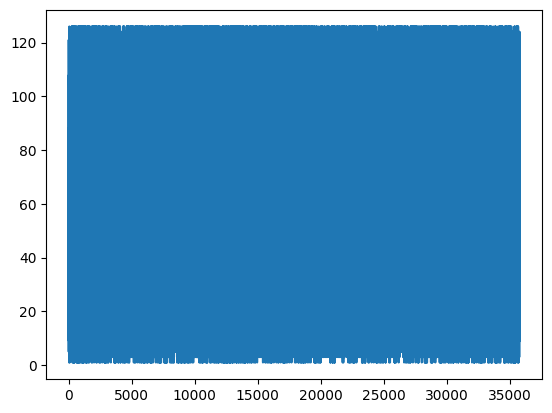

In [18]:
import matplotlib.pyplot as plt
plt.plot(clusters)

In [19]:
import numpy as np
unique, counts = np.unique(clusters, return_counts=True)
print(dict(zip(unique, counts)))

{np.int64(1): np.int64(470), np.int64(3): np.int64(657), np.int64(5): np.int64(1826), np.int64(9): np.int64(1004), np.int64(11): np.int64(1053), np.int64(12): np.int64(758), np.int64(13): np.int64(608), np.int64(14): np.int64(591), np.int64(18): np.int64(1356), np.int64(20): np.int64(898), np.int64(25): np.int64(1), np.int64(27): np.int64(382), np.int64(29): np.int64(674), np.int64(39): np.int64(1266), np.int64(43): np.int64(3), np.int64(50): np.int64(562), np.int64(54): np.int64(777), np.int64(55): np.int64(189), np.int64(60): np.int64(524), np.int64(62): np.int64(1188), np.int64(63): np.int64(1472), np.int64(65): np.int64(618), np.int64(67): np.int64(1308), np.int64(71): np.int64(703), np.int64(72): np.int64(1), np.int64(74): np.int64(1501), np.int64(76): np.int64(1), np.int64(79): np.int64(640), np.int64(80): np.int64(2049), np.int64(81): np.int64(1670), np.int64(82): np.int64(774), np.int64(88): np.int64(1024), np.int64(93): np.int64(597), np.int64(94): np.int64(889), np.int64(97):

In [20]:
np.save('vqvae_clusters.npy', clusters)